#  Natural Language Processing 

In [1]:
from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')





Using TensorFlow backend.


In [2]:
import nltk
import pandas as pd
import numpy as np

In [3]:
texts=pd.read_csv("/home/aman/anaconda3/spooky-author-identification/train.csv")

In [4]:
texts.head(10)

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL
5,id22965,"A youth passed in solitude, my best years spen...",MWS
6,id09674,"The astronomer, perhaps, at this point, took r...",EAP
7,id13515,The surcingle hung in ribands from my body.,EAP
8,id19322,I knew that you could not say to yourself 'ste...,EAP
9,id00912,I confess that neither the structure of langua...,MWS


In [5]:
byauthor=texts.groupby("author")   ##split the data byauthor

In [6]:
texts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19579 entries, 0 to 19578
Data columns (total 3 columns):
id        19579 non-null object
text      19579 non-null object
author    19579 non-null object
dtypes: object(3)
memory usage: 459.0+ KB


In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/aman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


False

In [8]:
wordfreqbyauthor=nltk.probability.ConditionalFreqDist()

In [9]:
byauthor.size()

author
EAP    7900
HPL    5635
MWS    6044
dtype: int64

In [10]:
for name,group in byauthor:
    
    sentence=group['text'].str.cat(sep=' ')
    
    sentences=sentence.lower()
    
    tokens = nltk.tokenize.word_tokenize(sentences)
    
    frequency=nltk.FreqDist(tokens)
    
    wordfreqbyauthor[name]=(frequency)
    
# now we have an dictionary where each entry is the frequency distrobution
# of words for a specific author. 

In [11]:
a={"name": "amabdarasj",
  "age": "fgrogihohfg"}

In [12]:
a.pop("name")

'amabdarasj'

In [14]:
a

{'age': 'fgrogihohfg'}

Now we can look at how often each writer uses specific words. Since this is a Halloween competition, how about "blood", "scream" and "fear"? 👻😨🧛‍♀️

In [13]:
## Here we see the freq of word 'blood'
for i in wordfreqbyauthor.keys():
    print("blood: ",i)
    print(wordfreqbyauthor[i].freq('blood'))
    
print()

## Here we see the freq of word 'blood'
for i in wordfreqbyauthor.keys():
    print("scream: ",i)
    print(wordfreqbyauthor[i].freq('scream'))
    
print()

## Here we see the freq of word 'blood'
for i in wordfreqbyauthor.keys():
    print("fear: ",i)
    print(wordfreqbyauthor[i].freq('fear'))
    
print()





blood:  EAP
0.00014645324695463396
blood:  HPL
0.0002298361842596689
blood:  MWS
0.00022772649518331984

scream:  EAP
1.72297937593687e-05
scream:  HPL
9.193447370386757e-05
scream:  MWS
2.647982502131626e-05

fear:  EAP
0.0001033787625562122
fear:  HPL
0.0005745904606491723
fear:  MWS
0.0006196279054988005



In [14]:
wordfreqbyauthor['HPL'].freq('blood')

0.0002298361842596689

In [15]:
wordfreqbyauthor['MWS'].freq('blood')

0.00022772649518331984

##in natural language processing we filter out the useless data. these useless data are call stop words

In [16]:
train=pd.read_csv("/home/aman/anaconda3/spooky-author-identification/train.csv")
test=pd.read_csv("/home/aman/anaconda3/spooky-author-identification/test.csv")
sample=pd.read_csv("/home/aman/anaconda3/spooky-author-identification/sample_submission.csv")

In [17]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [18]:
lbl_enc=preprocessing.LabelEncoder()

In [19]:
y=lbl_enc.fit_transform(train.author.values)

In [20]:
num_class=3

In [21]:
x_train, x_dev, y_train, y_dev = train_test_split(train.text.values, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_dev = (np.arange(num_class) == y_dev[:, None]).astype(np.float32)

In [22]:
y_dev.shape

(1958, 3)

In [23]:
y_train.shape

(17621, 3)

In [24]:
print(x_train.shape)
print(x_dev.shape)

(17621,)
(1958,)


In [25]:
# Always start with these features. They work (almost) everytime!
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

In [26]:
tfv.fit(list(x_train)+list(x_dev))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=3, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=1, stop_words='english', strip_accents='unicode',
                sublinear_tf=1, token_pattern='\\w{1,}', tokenizer=None,
                use_idf=1, vocabulary=None)

In [27]:
x_train_tfv=tfv.transform(x_train)
x_dev_tfv=tfv.transform(x_dev)

In [28]:
x_dev_tfv.shape

(1958, 15102)

In [29]:
x_train_tfv.todense()


matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [30]:
x_train_tfv.data

array([0.24694244, 0.31534174, 0.26213576, ..., 0.32150132, 0.31320636,
       0.37073425])

In [31]:
x_train_tfv.indptr

array([     0,     11,     18, ..., 198504, 198513, 198521], dtype=int32)

## Bag of Words method.

for reference:_ https://stackabuse.com/python-for-nlp-creating-bag-of-words-model-from-scratch/

In [32]:
import random
import string
import bs4 as bs  
import urllib.request  
import re 
import heapq

In [33]:
raw_html=urllib.request.urlopen('https://en.wikipedia.org/wiki/Natural_language_processing')

In [34]:
raw_html=raw_html.read()
article_html=bs.BeautifulSoup(raw_html,'lxml')

In [35]:
article_paragraphs = article_html.find_all('p')


In [36]:
article_text=''
for para in article_paragraphs:
    article_text+=para.text

In [37]:
corpus=nltk.sent_tokenize(article_text)

In [38]:
for i in range(len(corpus)):
    corpus[i]=corpus[i].lower()
    corpus[i]=re.sub(r'\W',' ',corpus [i])
    corpus[i]=re.sub(r'\s+',' ',corpus [i])

In [39]:
word_freq={}
for sentence in corpus:
    tokens=nltk.word_tokenize(sentence)
    for token in tokens:
        if token not in word_freq.keys():
            word_freq[token]=1
        else:
            word_freq[token]+=1

In [40]:
word_freq

{'natural': 20,
 'language': 26,
 'processing': 17,
 'nlp': 8,
 'is': 26,
 'a': 44,
 'subfield': 1,
 'of': 89,
 'linguistics': 7,
 'computer': 3,
 'science': 3,
 'information': 5,
 'engineering': 1,
 'and': 31,
 'artificial': 2,
 'intelligence': 4,
 'concerned': 1,
 'with': 7,
 'the': 97,
 'interactions': 1,
 'between': 2,
 'computers': 2,
 'human': 4,
 'languages': 2,
 'in': 35,
 'particular': 1,
 'how': 2,
 'to': 36,
 'program': 1,
 'process': 2,
 'analyze': 1,
 'large': 4,
 'amounts': 2,
 'data': 10,
 'challenges': 1,
 'frequently': 2,
 'involve': 1,
 'speech': 4,
 'recognition': 2,
 'understanding': 3,
 'generation': 1,
 'history': 1,
 'generally': 3,
 'started': 1,
 '1950s': 1,
 'although': 1,
 'work': 3,
 'can': 5,
 'be': 6,
 'found': 2,
 'from': 6,
 'earlier': 1,
 'periods': 1,
 '1950': 1,
 'alan': 1,
 'turing': 2,
 'published': 3,
 'an': 6,
 'article': 1,
 'titled': 1,
 'computing': 1,
 'machinery': 1,
 'which': 10,
 'proposed': 1,
 'what': 1,
 'now': 2,
 'called': 2,
 'test': 

In [41]:
len(word_freq)

649

In [42]:
most_freq = heapq.nlargest(200, word_freq, key=word_freq.get)

In [43]:
len(most_freq)

200

In [44]:
sentence_vector=[]
for sentence in corpus:
    sentence_tokes=nltk.word_tokenize(sentence)
    set_toke=[]
    for token in most_freq:
        if token in sentence_tokes:
            set_toke.append(1)
        else:
            set_toke.append(0)
    sentence_vector.append(set_toke)
    

In [45]:
senVect=np.asarray(sentence_vector)

In [46]:
senVect

array([[1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

Here we lower the content

In [47]:
for i in range(len(x_train)):
    x_train[i]=x_train[i].lower()
    x_train[i]=re.sub(r'\W',' ',x_train[i])
    x_train[i]=re.sub(r'\s+',' ',x_train [i])

# 2.Here we remove some..

% Strip all HTML
% Looks for any expression that starts with < and ends with > and replace
% and does not have any < or > in the tag it with a space
email_contents = regexprep(email_contents, '<[^<>]+>', ' ');

% Handle Numbers
% Look for one or more characters between 0-9
email_contents = regexprep(email_contents, '[0-9]+', 'number');

% Handle URLS
% Look for strings starting with http:// or https://
email_contents = regexprep(email_contents, ...
                           '(http|https)://[^\s]*', 'httpaddr');

% Handle Email Addresses
% Look for strings with @ in the middle
email_contents = regexprep(email_contents, '[^\s]+@[^\s]+', 'emailaddr');

% Handle $ sign
email_contents = regexprep(email_contents, '[$]+', 'dollar');

In [48]:
a='to substcribe my channel plz follow this link- https://gaana.com/song/dil-ka-qaraar or you can follow me on fb-  https://www.facebook.com/aman.darash.37'

In [49]:
a='my name is>then the 6799[obey the rule]'

In [50]:
s=re.sub(r'[0-9]+','number',a)

In [51]:
s=re.sub(r'[^\s]+@[^\s]+','emailaddr',a)

In [52]:
s=re.sub(r'(http|https)://[^\s]*', 'httpaddr',a)

In [53]:
s=re.sub(r'<[^<>]+>','',a)

In [54]:
def processcStat(content):
    for i in range(len(content)):
        content[i]=re.sub(r'[0-9]+','number',content[i])
        content[i]=re.sub(r'[^\s]+@[^\s]+','emailaddr',content[i])
        content[i]=re.sub(r'(http|https)://[^\s]*', 'httpaddr',content[i])
        content[i]=re.sub(r'<[^<>]+>','',content[i])
        

In [55]:
processcStat(x_train)

In [53]:
m=x_train[1]

In [54]:
m.lower()

' no he said oh no a member of my family my niece and a most accomplished woman '

In [56]:
word_freq={}
for sentence in x_train:
    sentence=sentence.lower()
    tokens=nltk.word_tokenize(sentence)
    for token in tokens:
        if token not in word_freq.keys():
            word_freq[token]=1
        else:
            word_freq[token]+=1

In [57]:
aman=word_freq.copy()

In [57]:
x_train

array(['her hair was the brightest living gold and despite the poverty of her clothing seemed to set a crown of distinction on her head ',
       ' no he said oh no a member of my family my niece and a most accomplished woman ',
       'the magistrate appeared at first perfectly incredulous but as i continued he became more attentive and interested i saw him sometimes shudder with horror at others a lively surprise unmingled with disbelief was painted on his countenance ',
       ...,
       'the medical testimony spoke confidently of the virtuous character of the deceased ',
       'when we arrived after a little rest he led me over the house and pointed out to me the rooms which my mother had inhabited ',
       'some were destroyed the major part escaped by quick and well ordered movements and danger made them careful '],
      dtype=object)

In [58]:
len(word_freq)

24005

In [58]:
from sklearn import metrics

In [63]:

for words in aman.keys():
    if words in stopwords.words():
        word_freq.pop(words)

In [59]:
word_freq['i']

9758

In [60]:
len(word_freq)

24005

In [63]:
most_freq=heapq.nlargest(300, word_freq, key=word_freq.get)

In [64]:
most_freq

['the',
 'of',
 'and',
 'to',
 'i',
 'a',
 'in',
 'was',
 'that',
 'my',
 'it',
 'had',
 'he',
 'with',
 'his',
 'as',
 'for',
 'not',
 'which',
 'but',
 'at',
 'me',
 'from',
 'by',
 'is',
 'this',
 'on',
 'be',
 'her',
 'were',
 'have',
 'all',
 'you',
 'an',
 'we',
 'or',
 'no',
 'one',
 'so',
 'him',
 'when',
 'they',
 'been',
 'upon',
 's',
 'there',
 'could',
 'she',
 'its',
 'more',
 'would',
 'now',
 'their',
 'what',
 'some',
 'our',
 'are',
 'into',
 'than',
 'will',
 'very',
 'if',
 'who',
 'only',
 'them',
 'then',
 'up',
 'man',
 'before',
 'these',
 'about',
 'any',
 'yet',
 'said',
 'did',
 'even',
 'out',
 'time',
 'your',
 'can',
 'might',
 'after',
 'like',
 'must',
 'old',
 'most',
 'us',
 'first',
 'over',
 'other',
 'through',
 'never',
 'night',
 'life',
 'do',
 'such',
 'found',
 'made',
 'should',
 'eyes',
 'seemed',
 'those',
 'little',
 'while',
 'great',
 'still',
 'myself',
 'every',
 'long',
 'day',
 'saw',
 'has',
 'where',
 'many',
 'own',
 'well',
 'agai

In [65]:
most_freq

['the',
 'of',
 'and',
 'to',
 'i',
 'a',
 'in',
 'was',
 'that',
 'my',
 'it',
 'had',
 'he',
 'with',
 'his',
 'as',
 'for',
 'not',
 'which',
 'but',
 'at',
 'me',
 'from',
 'by',
 'is',
 'this',
 'on',
 'be',
 'her',
 'were',
 'have',
 'all',
 'you',
 'an',
 'we',
 'or',
 'no',
 'one',
 'so',
 'him',
 'when',
 'they',
 'been',
 'upon',
 's',
 'there',
 'could',
 'she',
 'its',
 'more',
 'would',
 'now',
 'their',
 'what',
 'some',
 'our',
 'are',
 'into',
 'than',
 'will',
 'very',
 'if',
 'who',
 'only',
 'them',
 'then',
 'up',
 'man',
 'before',
 'these',
 'about',
 'any',
 'yet',
 'said',
 'did',
 'even',
 'out',
 'time',
 'your',
 'can',
 'might',
 'after',
 'like',
 'must',
 'old',
 'most',
 'us',
 'first',
 'over',
 'other',
 'through',
 'never',
 'night',
 'life',
 'do',
 'such',
 'found',
 'made',
 'should',
 'eyes',
 'seemed',
 'those',
 'little',
 'while',
 'great',
 'still',
 'myself',
 'every',
 'long',
 'day',
 'saw',
 'has',
 'where',
 'many',
 'own',
 'well',
 'agai

In [66]:
sentence_vector=[]
for sentence in x_train:
    sentence=sentence.lower()
    sent_token=nltk.word_tokenize(sentence)
    set_toke=[]
    for token in most_freq:
        if token in sent_token:
            set_toke.append(1)
        else:
            set_toke.append(0)
    sentence_vector.append(set_toke)

In [67]:
setVect=np.asarray(sentence_vector)

In [68]:
setVect[0:8000].T

array([[1, 0, 1, ..., 1, 0, 1],
       [1, 1, 0, ..., 1, 0, 1],
       [1, 1, 1, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [69]:
X_flatten=setVect.T

In [70]:
X_flatten.shape

(300, 17621)

In [84]:
x_t=setVect1.T

In [85]:
x_t.shape

(300, 1958)

In [72]:
y_flatten=y_train.T

In [73]:
y_flatten.shape

(3, 17621)

In [86]:
y_t=y_dev.T

In [87]:
y_t.shape

(3, 1958)

In [76]:
y_flatten.shape

(3, 17621)

In [77]:
from sklearn.ensemble import RandomForestClassifier

In [78]:
clf=RandomForestClassifier(n_estimators=100)

In [73]:
clf.fit(x_train_tfv,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [81]:
y_pred=clf.predict(x_dev_tfv)

In [103]:
y_dev.shape

(1958, 3)

In [104]:
y_pred.shape

(1958, 3)

In [82]:
metrics.accuracy_score(y_dev,y_pred)

0.6001021450459653

In [104]:
predict(x_t,y_t,parameters)

now the accuracy is 61.13%


## 2. here we use Deep Learning

In [79]:
import time
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *
from dnn_utils_v2 import sigmoid, sigmoid_backward, relu, relu_backward
import sklearn
import sklearn.datasets
import sklearn.linear_model


import csv
np.random.seed(1)

In [80]:
from nltk.corpus import stopwords

In [81]:
from sklearn.model_selection import train_test_split
from sklearn import svm

In [79]:
clf = svm.SVC(kernel="linear") 

In [113]:
setVect.shape

(17621, 300)

In [127]:
clf.fit(x_train_tfv,y_train)

ValueError: bad input shape (17621, 3)

In [88]:
x_dev.shape

(1958,)

In [89]:
y_dev.shape

(1958, 3)

In [90]:
sentence_vector1=[]
for sentence in x_dev:
    sentence=sentence.lower()
    sent_token=nltk.word_tokenize(sentence)
    set_toke=[]
    for token in most_freq:
        if token in sent_token:
            set_toke.append(1)
        else:
            set_toke.append(0)
    sentence_vector1.append(set_toke)

In [83]:
setVect1=np.asarray(sentence_vector1)

In [70]:
ypred=clf.predict(setVect1)

In [106]:
metrics.accuracy_score(ydev,ypred)

NameError: name 'ydev' is not defined

In [91]:
def linear_forword(A,w,b):
    
    Z=np.dot(w,A)+b
    assert(Z.shape==(w.shape[0],A.shape[1]))
    cache=(A,w,b)
    return Z,cache

In [92]:
def initialize_parameters(n_x,n_h,n_y):
    
    ###here we conder to initialize the parameter#####
    w1=np.random.randn(n_h,n_x)*0.01
    b1=np.zeros((n_h,1))
    w2=np.random.randn(n_y,n_h)*0.01
    b2=np.zeros((n_y,1))
    
    ##HERE WE CHECK THE PARAMTERS
    assert(w1.shape==(n_h,n_x))
    assert(b1.shape==(n_h,1))
    assert(w2.shape==(n_y,n_h))
    assert(b2.shape==(n_y,1))
    
    parameters={"W1":w1,
               "b1":b1,
               "W2":w2,
               "b2":b2}
    return parameters
    

In [93]:
def L_model_forwrd(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (3,X.shape[1]))
            
    return AL, caches

In [94]:
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (there are (L-1) or them, indexes from 0 to L-2)
                the cache of linear_activation_forward() with "sigmoid" (there is one, index L-1)
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [101]:
parameters = initialize_parameters(n_x,n_h,n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
#print(parameters["b2"].shape)
#print(X_flatten.shape)

W1 = [[ 1.62434536e-02 -6.11756414e-03 -5.28171752e-03 ...  7.84770651e-03
  -9.55425262e-03  5.85910431e-03]
 [ 2.06578332e-02 -1.47115693e-02 -8.30171895e-03 ...  9.86352180e-03
  -4.66154857e-03  1.38499134e-02]
 [-1.07296428e-02  4.95158611e-03 -9.52062101e-03 ... -1.45832446e-02
   4.94341651e-03 -1.49419377e-02]
 ...
 [-3.89270875e-03  1.11351353e-03 -2.58030601e-04 ... -7.72099866e-05
   2.49801193e-03 -1.87481240e-02]
 [ 3.95088442e-03 -1.34564911e-02  1.45737463e-03 ... -1.00051781e-02
   1.44122504e-02  1.75916528e-02]
 [ 1.51240457e-03  5.78534800e-03 -3.52116845e-03 ...  3.21586303e-04
   2.05216338e-02 -4.65932584e-03]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]


In [93]:
n_y

3

In [88]:
W1=parameters['W1']
b1=parameters['b1']
W2=parameters['W2']
b2=parameters['b2']

In [98]:
k=np.dot(W1,X_flatten)+b1

In [101]:
z1,actvation_cache=relu(k)

In [104]:
k1=np.dot(W2,z1)+b2

In [106]:
z2,activation_cache2=sigmoid(k1)

In [71]:
y_flatten.shape

(3, 17621)

In [112]:
z2.shape

(3, 17621)

In [114]:
m=17621

In [123]:
ss=(y_flatten*np.log(z2))+(1-y_flatten)*np.log(1-z2)

In [133]:
l=np.sum(ss,axis=1)

In [140]:
cost=-sum(l/m)

In [141]:
cost

2.0797609546975835

In [119]:
2+5*10

52

In [146]:
compute_cost1(z2,y_flatten)

0.6932536515658622

In [102]:
def compute_cost1(AL, Y):
    
    m=Y.shape[1]
    cost =-sum((Y*np.log(AL)+(1-Y)*(np.log(1-AL))).T)/m
    cost=np.squeeze(cost)
    cost=np.mean(cost)
    assert(cost.shape==())
    
    return cost   

In [103]:
def linear_activation_backword(dA,cache,activation):
    
    linear_cache,activation_cache=cache
    if activation=="sigmoid":
        dz=sigmoid_backward(dA,activation_cache)
        dA_prev,dw,db=linear_backword(dz,linear_cache)
    elif activation=="relu":
        dz=re# GRADED FUNCTION: linear_forward

def linear_forward(A, W, b):
    
    ### START CODE HERE ### (≈ 1 line of code)
    Z = np.dot(W,A)+b
    ### END CODE HERE ###
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [104]:
def linear_activation_forword(A_prev,w,b,activation):
    
    ##WE HAVE FOUND THE ACTIVATION WITH THE RESTRICTION
    if activation=="sigmoid":
        Z,linear_cache=linear_forword(A_prev,w,b)
        A,activation_cache=sigmoid(Z)
    ##IF THE ACTIVATION IS RELU THEN
    elif activation=="relu":
        Z,linear_cache=linear_forword(A_prev,w,b)
        A,activation_cache=relu(Z)
    
    ##VERYFYING THE SHAPE OF ACTIVATION USING ASSERT
    assert(A.shape==(w.shape[0],A_prev.shape[1]))
    cache=(linear_cache,activation_cache)
    
    return A,cache 


In [105]:
def linear_backword(dz,cache):
    
    A_prev,w,b=cache
    m=A_prev.shape[1]
    ##HERE WE GO WITH BACKPROPAGATION
    dw=(1/m)*np.dot(dz,A_prev.T)
    db=(1/m)*np.sum(dz,axis=1,keepdims=True)
    dA_prev=np.dot(w.T,dz)
    
    assert(dw.shape==w.shape)
    assert(db.shape==b.shape)
    assert(dA_prev.shape==A_prev.shape)
    
    return dA_prev,dw,db
    


In [133]:
n_x=len(X_flatten)
n_h=80
n_y=3
layers_dims=(n_x,500,80,500,3)

In [134]:
layers_dims[0]

300

In [107]:
def linear_activation_backword(dA,cache,activation):
    
    linear_cache,activation_cache=cache
    if activation=="sigmoid":
        dz=sigmoid_backward(dA,activation_cache)
        dA_prev,dw,db=linear_backword(dz,linear_cache)
    elif activation=="relu":
        dz=relu_backward(dA,activation_cache)
        dA_prev,dw,db=linear_backword(dz,linear_cache)
    
    return dA_prev,dw,db

In [108]:
def linear_activation_backword(dA,cache,activation):
    
    linear_cache,activation_cache=cache
    if activation=="sigmoid":
        dz=sigmoid_backward(dA,activation_cache)
        dA_prev,dw,db=linear_backword(dz,linear_cache)
    elif activation=="relu":
        dz=relu_backward(dA,activation_cache)
        dA_prev,dw,db=linear_backword(dz,linear_cache)
    
    return dA_prev,dw,db
    
    

In [109]:
def softmax_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    e_x = np.exp(Z - np.max(Z))
    s=e_x / e_x.sum()
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ


In [110]:
def update_parameters(parameters,grads,learning_rate):
    L=len(parameters)//2
    for  l in range(L):
        parameters["W"+str(l+1)]=parameters["W"+str(l+1)]- learning_rate*grads["dW"+str(l+1)]
        parameters["b"+str(l+1)]=parameters["b"+str(l+1)]- learning_rate*grads["db"+str(l+1)]
    
    return parameters

In [111]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.075, num_iterations = 3000, print_cost=False):
    
    costs=[]
    grad={}
    n_x,n_h,n_y=layers_dims
    
    ##INITIALIZE THE PARAMETERS
    parameters=initialize_parameters(n_x,n_h,n_y)
    ##here we introduce the parameters w1,w2,b1,b2
    w1=parameters["W1"]
    b1=parameters["b1"]
    w2=parameters["W2"]
    b2=parameters["b2"]
    
    ##AGAIN WE LOOP THE GRAD FUNCTION#################
    for i in range(0,num_iterations):
        
        A1,cache1=linear_activation_forword(X,w1,b1,activation="relu")
        A2,cache2=linear_activation_forword(A1,w2,b2,activation="sigmoid")
        
        ##COMPUTE COST 
        cost=compute_cost1(A2,Y)
        
        ## INITIALIZE THE BACKWORD PAPAMWTERS
        dA2=-(np.divide(Y,A2)-np.divide(1-Y,1-A2))
        
        ## HERE WE INITIALIZE THE LINEAR BACKWORD PROPAGATION
        dA1,dw2,db2=linear_activation_backword(dA2,cache2,activation="sigmoid")
        dA2,dw1,db1=linear_activation_backword(dA1,cache1,activation="relu")
        
        ## set grads ['dW1'] to dw1, f=grads['db1']
        grad['dW1']=dw1
        grad['db1']=db1
        grad['dW2']=dw2
        grad['db2']=db2
        
        ## update the parameters
        parameters=update_parameters(parameters,grad,learning_rate)
        
        ## retrieve w1,w2,b1,b2 from the parameters
        w1=parameters['W1']
        b1=parameters['b1']
        w2=parameters['W2']
        b2=parameters['b2']
        
        ### print the cost every 100 training examples
        if print_cost and i%100==0:
            print("Cost after iteration {}: {}".format(i,cost))
        if print_cost and i%100==0:
            costs.append(cost)
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations(per hundreds)')
    plt.title("Learning rate= "+str(learning_rate))
    plt.show()
    return parameters
       

In [99]:
tic=time.time()
parameters = two_layer_model(X_flatten, y_flatten, layers_dims = (n_x, 800, n_y), num_iterations = 3000, print_cost=True)
toc=time.time()
print("total time req:  "+str(toc-tic))

Cost after iteration 0: 0.6929841381544447


KeyboardInterrupt: 

In [135]:
predict(x_t,y_t,parameters)

now the accuracy is 73.95%


In [112]:
parameters

{'W1': array([[ 1.62434536e-02, -6.11756414e-03, -5.28171752e-03, ...,
          7.84770651e-03, -9.55425262e-03,  5.85910431e-03],
        [ 2.06578332e-02, -1.47115693e-02, -8.30171895e-03, ...,
          9.86352180e-03, -4.66154857e-03,  1.38499134e-02],
        [-1.07296428e-02,  4.95158611e-03, -9.52062101e-03, ...,
         -1.45832446e-02,  4.94341651e-03, -1.49419377e-02],
        ...,
        [-3.89270875e-03,  1.11351353e-03, -2.58030601e-04, ...,
         -7.72099866e-05,  2.49801193e-03, -1.87481240e-02],
        [ 3.95088442e-03, -1.34564911e-02,  1.45737463e-03, ...,
         -1.00051781e-02,  1.44122504e-02,  1.75916528e-02],
        [ 1.51240457e-03,  5.78534800e-03, -3.52116845e-03, ...,
          3.21586303e-04,  2.05216338e-02, -4.65932584e-03]]),
 'b1': array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
       

In [192]:
most_freq=[word for word in most_freq if not word in stopwords.words()]

In [194]:
len(most_freq)

467

In [82]:
y_pred.T[0:10]

array([[0.33725037, 0.0120133 , 0.77939093],
       [0.3203433 , 0.23555779, 0.36997337],
       [0.56714509, 0.13459648, 0.20939841],
       [0.58336389, 0.23080498, 0.12164241],
       [0.15971185, 0.47186056, 0.30910669],
       [0.36129568, 0.28528358, 0.2300418 ],
       [0.06668249, 0.11782098, 0.83821917],
       [0.03035653, 0.04873479, 0.94244696],
       [0.34366124, 0.0756463 , 0.59514489],
       [0.64274527, 0.04651778, 0.34996358]])

In [92]:
y_t.shape

(3, 1958)

In [104]:
from sklearn import preprocessing

In [162]:
lb = preprocessing.LabelBinarizer()

In [93]:
y_p=np.zeros((y_pred.T.shape))
i=0
for l in y_pred.T:
    l=l.tolist()
    indx=l.index(max(l))
    y_p[i][indx]=1
    i=i+1

In [88]:
l=y_pred.T[0]

In [183]:
l=l.tolist()

In [186]:
l.index(max(l))

2

In [85]:
y_t[0:10]

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]], dtype=float32)

In [94]:
y_p

array([[0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [93]:
y_p.shape

(1958, 3)

In [197]:
y_t=y_t.T

In [96]:
y_p.shape

(1958, 3)

In [200]:
y_t.shape

(1958, 3)

In [201]:
predict(x_t,y_t.T,parameters)

now the accuracy is 72.06%


In [98]:
metrics.accuracy_score(y_t,y_p)

0.6736465781409602

In [157]:
metrics.accuracy_score(y_t,y_p)

0.6664964249233912

In [202]:
vr.shape

(1, 300)

In [217]:
y_train[1]

array([1., 0., 0.], dtype=float32)

In [215]:
y_pred,caches=L_model_forward(vr.T, parameters)

In [216]:
y_pred

array([[0.89747464],
       [0.06619898],
       [0.05926075]])

In [113]:
def predict(X,Y,parameters):
    y_pred,caches=L_model_forwrd(X, parameters)
    
    ##convert it into normalize format
    y_p=np.zeros((y_pred.T.shape))
    i=0
    for l in y_pred.T:
        l=l.tolist()
        indx=l.index(max(l))
        y_p[i][indx]=1
        i=i+1
        
    ##finished the binarization
    y_t=Y.T
    accur=metrics.accuracy_score(y_t,y_p)
    print("now the accuracy is {0:.2f}%".format(accur*100))

In [114]:
def sentTokenizer(contents):
    sentence_vector1=[]
    for sentence in contents:
        sent_token=nltk.word_tokenize(sentence)
        set_toke=[]
        for token in most_freq:
            if token in sent_token:
                set_toke.append(1)
            else:
                set_toke.append(0)
        sentence_vector1.append(set_toke)
    setVect=np.asarray(sentence_vector1)
    
    return setVect

In [108]:
predict(X_flatten,y_flatten,parameters)

now the accuracy is 77.61%


In [103]:
cont='"No," he said, "oh, no a member of my family my niece, and a most accomplished woman."'

In [104]:
cont=cont.lower()
sent_token=nltk.word_tokenize(cont)
set_toke=[]
for token in most_freq:
    if token in sent_token:
        set_toke.append(1)
    else:
        set_toke.append(0)
vr=np.asarray(set_toke)

In [105]:
vr=vr.reshape(1,300)

In [106]:
vr.shape

(1, 300)

array(['Her hair was the brightest living gold, and despite the poverty of her clothing, seemed to set a crown of distinction on her head.',
       '"No," he said, "oh, no a member of my family my niece, and a most accomplished woman."',
       'The magistrate appeared at first perfectly incredulous, but as I continued he became more attentive and interested; I saw him sometimes shudder with horror; at others a lively surprise, unmingled with disbelief, was painted on his countenance.',
       ...,
       'The medical testimony spoke confidently of the virtuous character of the deceased.',
       'When we arrived, after a little rest, he led me over the house and pointed out to me the rooms which my mother had inhabited.',
       'Some were destroyed; the major part escaped by quick and well ordered movements; and danger made them careful.'],
      dtype=object)

In [144]:
predict(X_flatten,y_flatten,parameters)

now the accuracy is 40.35%


In [177]:
a.tolist()

[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]

In [174]:
a=[1,2,3,4]

In [175]:
a.index(3)

2

In [97]:
X_flatten.shape

(300, 17621)

In [124]:
layers_dims

(300, 200, 200, 3)

In [122]:
parmt=initialize_with_he(layers_dims)

In [125]:
W1=parmt["W1"]
b1=parmt['b1']
W2=parmt["W2"]
b2=parmt['b2']
W3=parmt["W3"]
b3=parmt['b3']


In [137]:
Z1=np.dot(W1,X_flatten)+b1
A1,caches=relu(Z1)
Z2=np.dot(W2,A1)+b2
A2,caches=relu(Z2)
Z3=np.dot(W3,A2)+b3
A3,caches=softmax(Z3)

In [152]:
Al,caches=forword_propagation(X_flatten,parameters)

In [155]:
Al

array([[2.13265595e-05, 2.02546988e-05, 1.19895133e-05, ...,
        2.14157369e-05, 1.63627790e-05, 1.81893989e-05],
       [1.99412499e-05, 1.70262331e-05, 2.33221770e-05, ...,
        1.82674038e-05, 1.95454120e-05, 1.86271684e-05],
       [1.79752605e-05, 2.22484902e-05, 2.01084849e-05, ...,
        2.02954210e-05, 2.19272764e-05, 1.95811140e-05]])

In [156]:
compute_cost1(Al,y_flatten)

3.627552023089111

In [117]:
a=np.log(-20)

/home/aman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


In [120]:
import math

In [121]:
if math.isnan(a)==False:
    print("Exist")
else:
    print("not exist")

not exist


In [122]:
Al,caches=L_model_forward(X_flatten, parameters)

In [123]:
Al.shape

(3, 17621)

In [114]:
(layers_dims)

(300, 200, 200, 3)

In [99]:
s_t[80]

array([0.47615686, 0.01383864, 0.71567659])

In [100]:
y_t.T[80]

array([1., 0., 0.], dtype=float32)

In [122]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    
    cache=x

    return e_x / e_x.sum(),cache

In [131]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.075, num_iterations = 3000, print_cost=False):#lr was 0.009

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forwrd(X, parameters)
        ### END CODE HERE ###
        #print("Forword propagation Complete ",i)
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        #print("cost function started ",i)
        cost = compute_cost1(AL, Y)
        if math.isnan(cost):
            break
        #print(cost)
        ### END CODE HERE ###
        #print("cost function completed ",i)
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        #print("Back propagation started ",i)
        grads = L_model_backward(AL, Y, caches)
        ### END CODE HERE ###
        #print("Back propagation completed ",i)
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.687130
Cost after iteration 100: 0.607203
Cost after iteration 200: 0.524310
Cost after iteration 300: 0.472534
Cost after iteration 400: 0.459136
Cost after iteration 500: 0.447342
Cost after iteration 600: 0.431738
Cost after iteration 700: 0.426302
Cost after iteration 800: 0.411182
Cost after iteration 900: 0.396955
Cost after iteration 1000: 0.388952
Cost after iteration 1100: 0.390868
Cost after iteration 1200: 0.393320
Cost after iteration 1300: 0.379501
Cost after iteration 1400: 0.360441
Cost after iteration 1500: 0.330737
Cost after iteration 1600: 0.351598
Cost after iteration 1700: 0.347700
Cost after iteration 1800: 0.338588
Cost after iteration 1900: 0.339455
Cost after iteration 2000: 0.302833
Cost after iteration 2100: 0.288240
Cost after iteration 2200: 0.239314
Cost after iteration 2300: 0.257365
Cost after iteration 2400: 0.272004
Cost after iteration 2500: 0.396539
Cost after iteration 2600: 0.179630
Cost after iteration 2700: 0.149534
Cost

/home/aman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


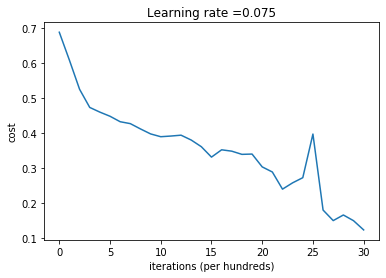

In [135]:
parameters=L_layer_model(X_flatten, y_flatten, layers_dims, learning_rate = 0.075, num_iterations = 3500, print_cost=True)

In [137]:
parameters

{'W1': array([[ 1.01072243e-01,  1.72408065e-02, -1.16256038e-01, ...,
          2.33468332e-02, -1.18392001e-01,  3.86533106e-02],
        [ 7.67307809e-02, -7.04839344e-02, -6.87859085e-02, ...,
          4.99774111e-02, -3.53930311e-02,  5.94871666e-02],
        [-5.42742861e-02,  4.11356573e-02, -4.89130798e-02, ...,
         -7.65994853e-02,  3.74548023e-02, -8.84041292e-02],
        ...,
        [ 4.28738823e-02, -1.29554256e-01,  3.33003936e-02, ...,
          3.77920144e-03, -3.52719738e-02, -6.88815737e-02],
        [ 4.17744542e-02, -8.53698251e-02, -9.96761975e-05, ...,
          2.17747672e-01,  4.16098154e-02, -1.82234646e-02],
        [ 3.32603892e-02, -6.26845299e-02, -6.23995837e-02, ...,
         -6.21533950e-02, -5.90819115e-02, -2.88935942e-02]]),
 'b1': array([[ 5.14419202e-02],
        [ 6.30818840e-03],
        [ 2.33659384e-03],
        [-4.55237523e-02],
        [-3.08380513e-01],
        [ 1.61815009e-03],
        [ 2.75124833e-02],
        [-3.80472305e-02],
 

In [138]:
predict(X_flatten,y_flatten,parameters)

now the accuracy is 60.37%


In [126]:
y_flatten.shape

(3, 17621)

In [139]:
predict(x_t,y_t,parameters)

now the accuracy is 49.08%


## 4. Using regularization

In [140]:
def initialize_with_he(dims):
    
    L=len(dims)
    parameters={}
    for i in range(1,L):
        parameters['W'+str(i)]=np.random.randn(dims[i],dims[i-1])*(np.sqrt(2/dims[i-1]))
        parameters['b'+str(i)]=np.zeros((dims[i],1))
        
        assert(parameters['W' + str(i)].shape == (dims[i], dims[i-1]))
        assert(parameters['b' + str(i)].shape == (dims[i], 1))
    
    return parameters

In [141]:
def compute_cost_with_regularization(Al , Y,parameters, lambd=0.07):
    #print("MY name is aman")
    m=Y.shape[1]
    W1=parameters["W1"]
    W2=parameters["W2"]
    W3=parameters["W3"]
    
    cost=compute_cost1(Al, Y)
    #print("cross entropy: ",cost1)
    
    ## now defing the regularization in the fub=nction
    regularization= np.sum(np.square(W3))+np.sum(np.square(W2))+np.sum(np.square(W1))
    #print(regularization)
    
    ## now defing the regularization
    cost=cost+regularization*(lambd/(2*m))
    
    return cost

In [142]:
compute_cost_with_regularization(Al,y_flatten,parameters,lambd=0.07)

NameError: name 'Al' is not defined

In [143]:
def forword_propagation_with_dropout(X,parameters,keep_prob):
    # probagation ->RELU -> DROPOUT-> propagation ->RELU -> DROPOUT ->propagation ->sigmoid
    W1=parameters["W1"]
    b1=parameters["b1"]
    W2=parameters["W2"]
    b2=parameters["b2"]
    W3=parameters["W3"]
    b3=parameters["b3"]
    
    Z1=np.dot(W1,X)+b1
    A1,cache=relu(Z1)
    ## dropout------
    D1=np.random.rand(A1.shape[0],A1.shape[1])
    D1=(D1<keep_prob).astype(int)
    A1=np.multiply(A1,D1)
    A1=A1/keep_prob
    ##dropout......
    
    Z2=np.dot(W2,A1)+b2
    A2,cache=relu(Z2)
    ##dropout....
    D2=np.random.rand(A2.shape[0],A2.shape[1])
    D2=(D2<keep_prob).astype(int)
    A2=np.multiply(A2,D2)
    A2=A2/keep_prob
    ## dropout....
    
    Z3=np.dot(W3,A2)+b3
    A3,cache=sigmoid(Z3)
    
    caches=(Z1,D1,A1,W1,b1,Z2,D2,A2,W2,b2,Z3,A3,W3,b3)
    
    
    return A3,caches

In [144]:
def forword_propagation(X,parameters):
    #print("Its me")
    W1=parameters['W1']
    b1=parameters['b1']
    W2=parameters['W2']
    b2=parameters['b2']
    W3=parameters['W3']
    b3=parameters['b3']
    
    Z1=np.dot(W1,X)+b1
    A1,cache=relu(Z1)
    
    Z2=np.dot(W2,A1)+b2
    A2,cache=relu(Z2)
    
    Z3=np.dot(W3,A2)+b3
    A3,cache=sigmoid(Z3)
    
    cache=(Z1,A1,W1,b1,Z2,A2,W2,b2,Z3,A3,W3,b3)
    
    return A3,cache
    
    

In [145]:
def backword_propagation_with_regularization(X,Y,caches,lambd=0):
    
    m=X.shape[1]
    (Z1,A1,W1,b1,Z2,A2,W2,b2,Z3,A3,W3,b3)=caches
    
    dZ3=A3-Y
    dW3=1./m * np.dot(dZ3,A2.T)+((lambd*W3)/m)
    db3=1./m * np.sum(dZ3,axis=1,keepdims=True)
    
    dA2=np.dot(W3.T,dZ3)
    dZ2=np.multiply(dA2,np.int64(A2>0))
    dW2=1./m * np.dot(dZ2,A1.T)+((lambd*W2)/m)
    db2=1./m * np.sum(dZ2,axis=1,keepdims=True)
    
    dA1=np.dot(W2.T,dZ2)
    dZ1=np.multiply(dA1,np.int64(A1>0))
    dW1=1./m * np.dot(dZ1,X.T)+((lambd)/m)
    db1=1./m * np.sum(dZ1,axis=1,keepdims=True)
    
    gradients={ "dZ3":dZ3, "dW3": dW3, "db3": db3, "dA2": dA2,
               "dZ2":dZ2, "dW2": dW2, "db2": db2, "dA1": dA1,
                "dZ1":dZ1, "dW1": dW1, "db1": db1}
        
    return gradients

In [146]:
def backword_propagation_with_dropout(X,Y,caches,keep_prob):
    
    m=X.shape[1]
    (Z1,D1,A1,W1,b1,Z2,D2,A2,W2,b2,Z3,A3,W3,b3)=caches
    
    dZ3=A3-Y
    dW3=1./m * np.dot(dZ3,A2.T)
    db3=1./m * np.sum(dZ3,axis=1,keepdims=True)
    ##db3=np.sum(dZ,axis=1,keepdims=True)*(1/m)
    
    dA2=np.dot(W3.T,dZ3)
    ##Dropout
    dA2=dA2*D2
    dA2=dA2/keep_prob
    dZ2=np.multiply(dA2,np.int64(A2>0))
    dW2=1./m * np.dot(dZ2,A1.T)
    db2=1./m * np.sum(dZ2,axis=1,keepdims=True)
    
    dA1=np.dot(dW2.T,dZ2)
    ##dropout
    dA1=dA1*D1
    dA1=dA1/keep_prob
    dZ1=np.multiply(dA1,np.int64(A1>0))
    dW1=1./m * np.dot(dZ1,X.T)
    db1=1./m * np.sum(dZ1,axis=1,keepdims=True)
    
    gradients={ "dZ3":dZ3, "dW3": dW3, "db3": db3, "dA2": dA2,
               "dZ2":dZ2, "dW2": dW2, "db2": db2, "dA1": dA1,
                "dZ1":dZ1, "dW1": dW1, "db1": db1}
     
    return gradients
    
    
    
    

In [147]:
def model_com(X,Y,learning_rate,num_iters,lambd=0,keep_prob=1,print_cost=True):
    
    
    grads={}
    costs=[]
    m=X.shape[1]
    layer_dims=[X.shape[0],64,64,3]
    parameters=initialize_with_he(layer_dims)
    for i in range(0,num_iters):
        ##print("irteration no ",i)
        ## forword propagation :..
        if keep_prob==1:
            Al,caches=forword_propagation(X,parameters)
        elif keep_prob<1:
            Al,caches=forword_propagation_with_dropout(X,parameters,keep_prob)
        
        ### here we find cost funtion
        if lambd==0:
            cost=compute_cost1(Al,Y)
        elif lambd!=0:
            cost=compute_cost_with_regularization(Al,Y,parameters,lambd)
            
        assert(lambd==0 or keep_prob==1)
        if cost:
            continue
        else:
            break
        if math.isnan(cost):
            break
        ## backpropagation:.....
        if keep_prob==1 and lambd==0:
            grads=backword_propagation(X,Y,caches)
        
        elif keep_prob<1:
            grads=backword_propagation_with_dropout(X,Y,caches,keep_prob)
        
        elif lambd!=0:
            grads=backword_propagation_with_regularization(X,Y,caches,lambd)
        
        ##update parameters:.....
        parameters=update_parameters(parameters,grads,learning_rate)
        
        if print_cost and i%1000==0:
            print("cost after iteratrion {} : {}".format(i,cost))
        if print_cost and i%100==0:
            #print("cost after iteratrion {} : {}".format(i,cost))
            costs.append(cost)
    ##plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iteration (x1,1000)')
    plt.title("learning rate= "+str(learning_rate))
    plt.show()
    
    
    
    return parameters    

In [223]:
parameters=model_com(X_flatten, y_flatten,learning_rate=0.1,num_iters=15000,lambd=0.07,keep_prob=1,print_cost=True)

KeyboardInterrupt: 

### Note.. 

Here we have seen that regularization give better result on NLP data only for trainig data set
 1. it gives 95% accuracy on learning_rate=0.1 number of Iteration= 15000 and lambda=0.085

1.1  but gives 64% accuracy on cross validation set which is very bad 

In [220]:
predict(x_t,y_t,parameters)

now the accuracy is 55.87%


In [221]:
cost=

NameError: name 'nan' is not defined

In [147]:
layer_dims=[X_flatten.shape[0],64,64,3]

In [148]:
parameters=initialize_with_he(layers_dims)

In [149]:
parameters

{'W1': array([[ 0.00412967,  0.07104038, -0.03236389, ..., -0.12573891,
         -0.05606441,  0.11894395],
        [-0.1307399 , -0.12945585, -0.04925058, ...,  0.09685405,
          0.04427996,  0.04403341],
        [ 0.03114408, -0.00664743,  0.08291168, ..., -0.05767307,
          0.05877269,  0.06531139],
        ...,
        [-0.08126617, -0.01617538,  0.02146229, ...,  0.16244738,
         -0.13340518,  0.05174535],
        [ 0.16163921, -0.04903776,  0.06123141, ...,  0.08773717,
         -0.09166194,  0.00897791],
        [-0.19588928,  0.16513869, -0.09353748, ..., -0.14928163,
         -0.03193231,  0.00790219]]), 'b1': array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]

In [113]:
W1=parameters['W1']
b1=parameters['b1']
W2=parameters['W2']
b2=parameters['b2']
W3=parameters['W3']
b3=parameters['b3']

In [150]:
Al,caches=forword_propagation(X_flatten,parameters)

In [136]:
m=y_flatten.shape[1]

In [186]:
cost=compute_cost1(Al,y_flatten)

In [187]:
regularization=np.sum(np.square(W3))+np.sum(np.square(W2))+np.sum(np.square(W1))

In [188]:
cost+regularization*(0.07/(2*m))

0.6945726188826664

In [204]:
lambd=0.07

In [214]:
compute_cost_with_regularization(Al,y_flatten,parameters,lambd)

0.6945635280413861

In [138]:
-sum(y_flatten*np.log(Al)+(1-y_flatten)*np.log(1-Al))/m

array([1.02311996e-04, 1.62488836e-05, 5.30638455e-05, ...,
       2.25335484e-05, 1.31474476e-04, 1.49179747e-04])

In [116]:
cost=compute_cost_with_regularization(Al,y_flatten,lambd=0.07)

/home/aman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


In [117]:
cost

nan

In [131]:
grads=backword_propagation_with_regularization(X_flatten, y_flatten, caches, lambd=0.07)

In [256]:
grads["dZ3"].shape

(3, 17621)

In [146]:
parameters

{'W1': array([[-0.23861641, -0.05194905,  0.29840174, ..., -0.11816866,
         -0.11638322,  0.11474881],
        [ 0.08647265, -0.0551149 ,  0.17872811, ...,  0.0159752 ,
         -0.07423238,  0.08893638],
        [ 0.13281952, -0.04749088,  0.11541664, ..., -0.14858307,
          0.01376116, -0.01626743],
        ...,
        [ 0.05178087, -0.02946296, -0.20783337, ...,  0.08947978,
         -0.04419866, -0.04651467],
        [-0.11488594,  0.08910823,  0.24157111, ...,  0.06101895,
          0.00933461,  0.13332249],
        [-0.0185545 , -0.00231175,  0.15982814, ..., -0.02440985,
         -0.01889167, -0.01220399]]), 'b1': array([[ 3.42992037e-02],
        [ 3.62959028e-02],
        [-5.42846534e-02],
        [ 1.25239729e-01],
        [ 6.31239317e-02],
        [ 6.66052408e-02],
        [ 3.36849635e-03],
        [-1.04420417e-01],
        [ 1.06725619e-02],
        [ 8.18867196e-02],
        [-1.83625167e-01],
        [ 4.55449461e-02],
        [-3.58893789e-01],
        [ 6

## 5. Dropout technique

In [ ]:
parameters=model_com(X_flatten, y_flatten,learning_rate=0.075,num_iters=15000,lambd=0,keep_prob=0.5,print_cost=True)

In [170]:
def predict_dropout(X,Y,parameters,keep_prob):
    y_pred,caches=forword_propagation_with_dropout(X,parameters,keep_prob)
    
    ##convert it into normalize format
    y_p=np.zeros((y_pred.T.shape))
    i=0
    for l in y_pred.T:
        l=l.tolist()                                   ## convert them in list
        indx=l.index(max(l))                           ## find maximize in list
        y_p[i][indx]=1                                 ## using the put 1 in list
        i=i+1
        
    ##finished the binarization
    y_t=Y.T
    accur=metrics.accuracy_score(y_t,y_p)
    print("now the accuracy is {0:.2f}%".format(accur*100))     ###print the acuracy

In [172]:
predict_dropout(x_t,y_t,parameters,keep_prob=0.8)

now the accuracy is 45.91%


In [174]:
predict_dropout(X_flatten,y_flatten,parameters,keep_prob=0.8)

now the accuracy is 50.44%
